# Задание 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from matplotlib import rcParams
plot_w = 13
plot_h = 7
rcParams['figure.figsize'] = plot_w, plot_h
davis_df = pd.read_csv("datasets/Davis.csv")

In [2]:
davis_df

,Unnamed: 0,sex,weight,height,repwt,repht
0,1,M,77,182,77.0,180.0
1,2,F,58,161,51.0,159.0
2,3,F,53,161,54.0,158.0
3,4,M,68,177,70.0,175.0
4,5,F,59,157,59.0,155.0
...,...,...,...,...,...,...
195,196,M,74,175,71.0,175.0
196,197,M,83,180,80.0,180.0
197,198,M,81,175,NaN,NaN
198,199,M,90,181,91.0,178.0


## Вычисление пропорции мужчин в выборке

In [3]:
def male_proportion(df):
    df.groupby([df.sex == "M"]).count()
    M_count = len(df[df.sex == "M"].index)
    return M_count / len(df.index)
male_proportion(davis_df)

0.44

## Выявление аномалий

Text(0, 0.5, 'weight')

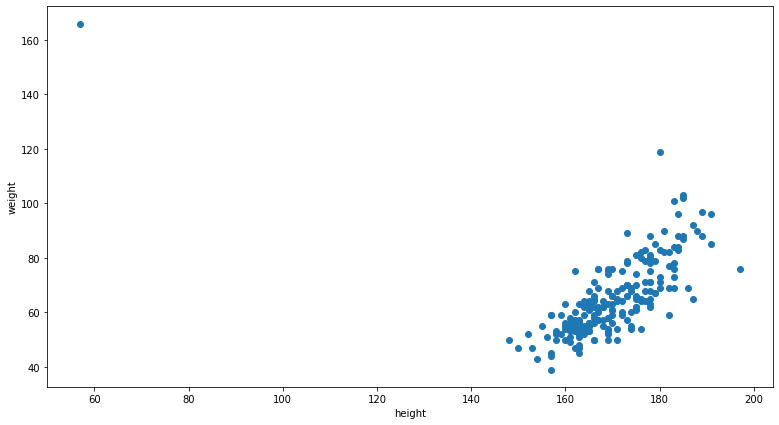

In [4]:
plt.scatter(x=davis_df["height"], y=davis_df["weight"])
plt.xlabel("height")
plt.ylabel("weight")

Text(0, 0.5, 'repwt')

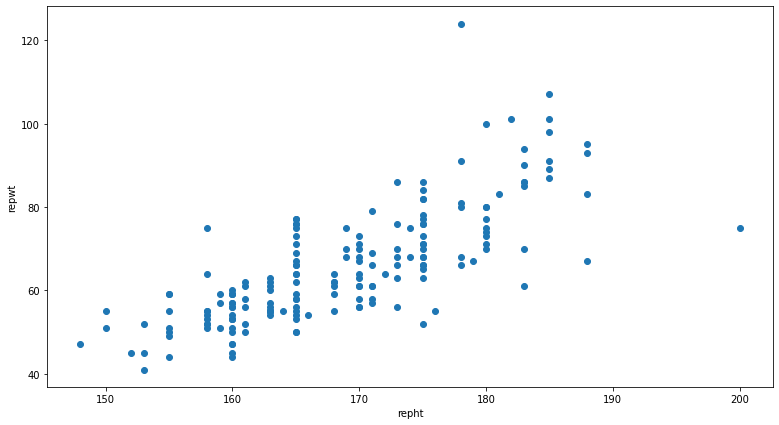

In [5]:
plt.scatter(x=davis_df["repht"], y=davis_df["repwt"])
plt.xlabel("repht")
plt.ylabel("repwt")

Text(0, 0.5, 'weight')

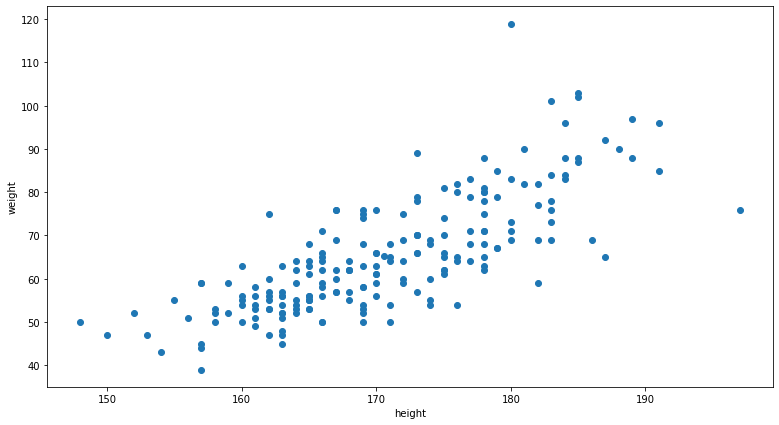

In [6]:
davis_df.where(davis_df["height"] > 100, inplace=True)
davis_df.fillna(davis_df.mean(), inplace=True)
plt.scatter(x=davis_df["height"], y=davis_df["weight"])
plt.xlabel("height")
plt.ylabel("weight")

## Разбиение выборки на 2 с сохранением пропорции:

In [7]:
male_proportion(davis_df)

0.44

In [8]:
male_davis_df = davis_df[davis_df.sex == "M"]
female_davis_df = davis_df[davis_df.sex == "F"]
train_davis_df = male_davis_df.sample(frac=0.5).append(female_davis_df.sample(frac=0.5))
test_davis_df = pd.concat([davis_df, train_davis_df]).drop_duplicates(keep=False)
male_proportion(train_davis_df), male_proportion(test_davis_df)

(0.44, 0.44)

## Отображение train-выборки на в виде точек на графике

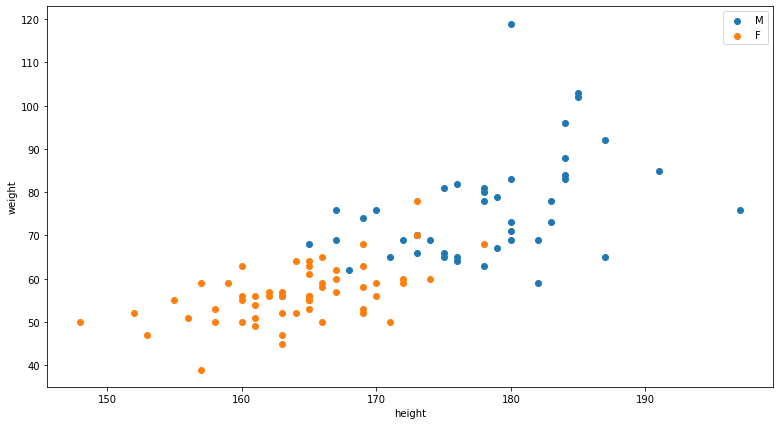

In [9]:
plt.scatter(x=train_davis_df.where(train_davis_df["sex"] == "M")["height"],
            y=train_davis_df.where(train_davis_df["sex"] == "M")["weight"], label="M")
plt.scatter(x=train_davis_df.where(train_davis_df["sex"] == "F")["height"],
            y=train_davis_df.where(train_davis_df["sex"] == "F")["weight"], label="F")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()

## Построение гистограмм роста и веса

### Общая

Text(0.5, 0, 'weight')

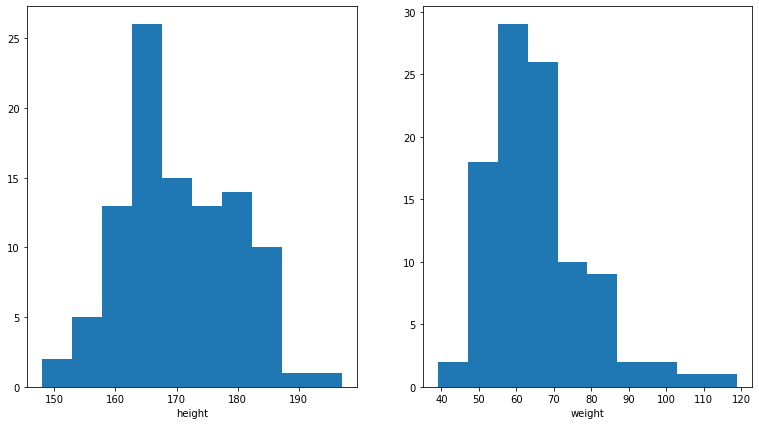

In [10]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df["weight"])
ax[1].set_xlabel("weight")

### Только мужчины

Text(0.5, 0, 'weight')

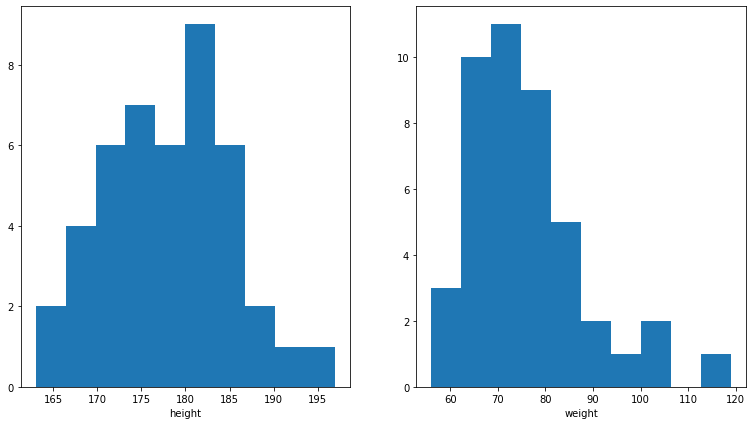

In [11]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="M")["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="M")["weight"])
ax[1].set_xlabel("weight")

### Только женщины

Text(0.5, 0, 'weight')

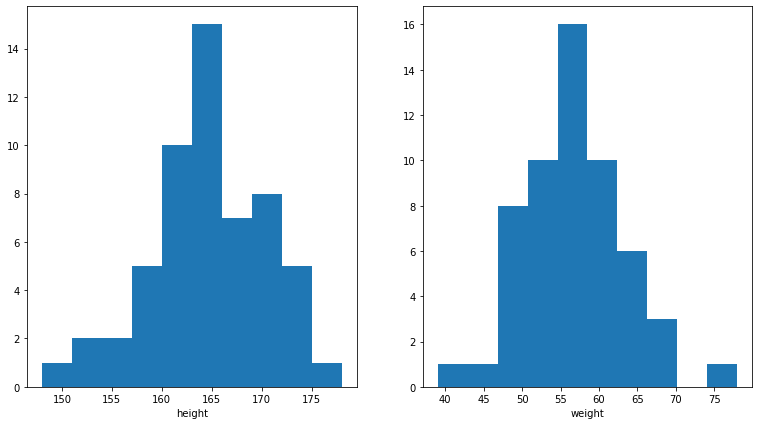

In [12]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="F")["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="F")["weight"])
ax[1].set_xlabel("weight")

## Построение гистограмм величин (repwt - weight) и (repht - height)

### Общая

Text(0.5, 0, 'repht - height')

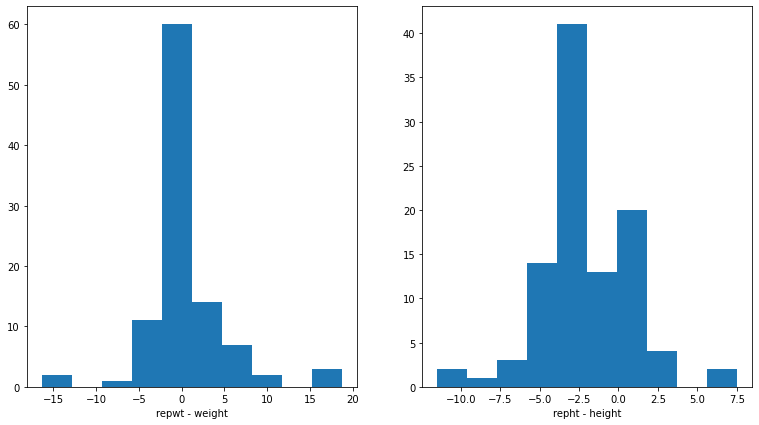

In [13]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df["repwt"] - train_davis_df["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df["repht"] - train_davis_df["height"])
ax[1].set_xlabel("repht - height")

### Только мужчины

Text(0.5, 0, 'repht - height')

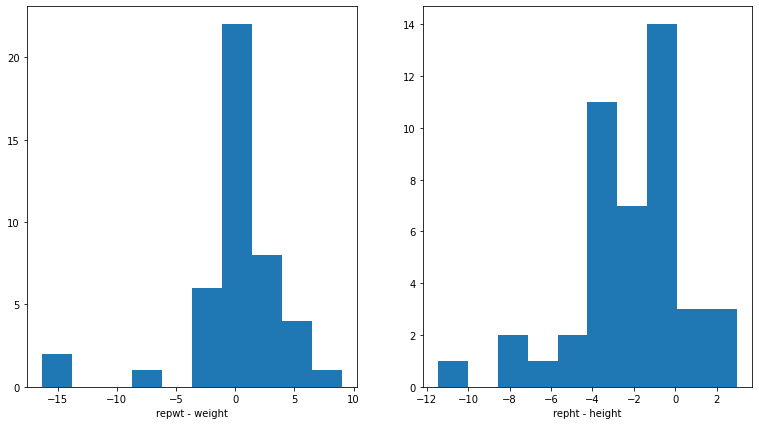

In [14]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="M")["repwt"] - train_davis_df.where(train_davis_df["sex"]=="M")["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="M")["repht"] - train_davis_df.where(train_davis_df["sex"]=="M")["height"])
ax[1].set_xlabel("repht - height")

### Только женщины

Text(0.5, 0, 'repht - height')

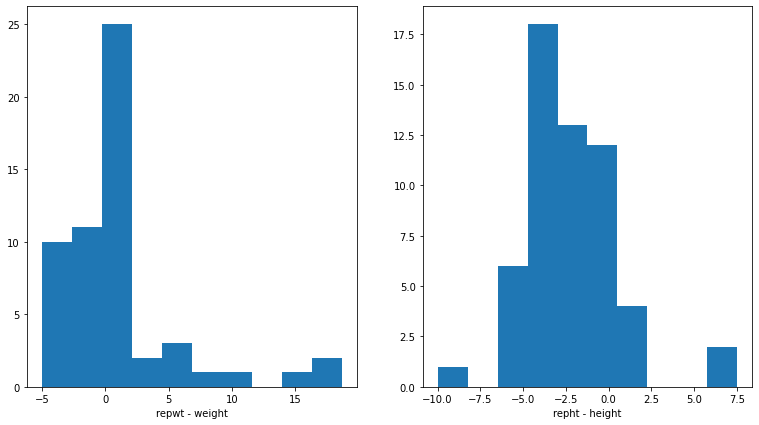

In [15]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="F")["repwt"] - train_davis_df.where(train_davis_df["sex"]=="F")["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="F")["repht"] - train_davis_df.where(train_davis_df["sex"]=="F")["height"])
ax[1].set_xlabel("repht - height")

## Построение генератора

In [16]:
class DataGenerator:
    def __init__(self):
        self.p_woman = None
        self.p_man = None
        self.mean_height = { "woman": None, "man": None }
        self.mean_weight = { "woman": None, "man": None }
        self.cov_matrix = { "woman": None, "man": None }
         
        
    def fit(self, df):
        self.p_man = male_proportion(df) 
        self.p_woman = 1 - self.p_man
        self.mean_height["woman"] = np.mean(df.where(df["sex"] == "F")["height"])
        self.mean_height["man"] = np.mean(df.where(df["sex"] == "M")["height"])
        self.mean_weight["woman"] = np.mean(df.where(df["sex"] == "F")["weight"])
        self.mean_weight["man"] = np.mean(df.where(df["sex"] == "M")["weight"])
        self.cov_matrix["woman"] = np.cov(df[df["sex"] == "F"]["height"].to_numpy(),
                                          df[df["sex"] == "F"]["weight"].to_numpy())
        self.cov_matrix["man"] = np.cov(df[df["sex"] == "M"]["height"].to_numpy(),
                                        df[df["sex"] == "M"]["weight"].to_numpy())
        return self
    
    
    def generate_points(self, n_points):
        result = []
        for i in range(n_points):
            sex = scipy.stats.distributions.bernoulli.rvs(self.p_woman)
            if(sex == 0):
                hw = np.random.multivariate_normal(mean=[self.mean_height["man"], self.mean_weight["man"]],
                                                   cov=self.cov_matrix["man"], size=1)
                result.append(np.array([sex, hw[:, 0][0], hw[:, 1][0]]))
            else:
                hw = np.random.multivariate_normal(mean=[self.mean_height["woman"], self.mean_weight["woman"]],
                                                   cov=self.cov_matrix["woman"], size=1)
                result.append(np.array([sex, hw[:, 0][0], hw[:, 1][0]]))
        return np.array(result, dtype=float)
    
    
    def log_likehood(self, df, sex):
        x = df[["height", "weight"]].values
        if sex == "M":
            mean_height = self.mean_height["man"]
            mean_weight = self.mean_weight["man"]
            cov_matrix = self.cov_matrix["man"]
            p = self.p_man
        else:
            mean_height = self.mean_height["woman"]
            mean_weight = self.mean_weight["woman"]
            cov_matrix = self.cov_matrix["woman"]
            p = self.p_woman
        result = p * scipy.stats.multivariate_normal.pdf(x=x, mean=[mean_height, mean_weight], cov=cov_matrix)
        return np.log(result)
    
    
    def mean_log_likehood(self, df, sex):
        return self.log_likehood(df, sex).sum() / len(df.index)

In [17]:
generator = DataGenerator()
generator.fit(train_davis_df)
generated_data = generator.generate_points(100)
generated_data

array([[  1.        , 156.84504002,  52.58382376],
       [  1.        , 174.44731147,  72.49259697],
       [  0.        , 180.97064008,  89.57908707],
       [  0.        , 174.39294227,  87.23423083],
       [  0.        , 180.06980793,  97.68405992],
       [  0.        , 176.18416841,  70.73714046],
       [  0.        , 182.73785909,  84.9162784 ],
       [  0.        , 170.14828926,  89.4794126 ],
       [  0.        , 171.85161774,  77.69195397],
       [  0.        , 169.74155484,  85.83418365],
       [  1.        , 163.8112118 ,  51.87589214],
       [  1.        , 169.24162903,  65.11063079],
       [  0.        , 175.39162939,  76.77847441],
       [  0.        , 174.17388315,  85.48344176],
       [  1.        , 162.41154466,  59.76894103],
       [  0.        , 177.64066485,  81.74538583],
       [  1.        , 159.00593269,  51.85591373],
       [  1.        , 171.63205931,  66.53741979],
       [  1.        , 164.29682533,  63.86980467],
       [  1.        , 165.71250

In [18]:
generated_df = pd.DataFrame( {"sex" : generated_data.T[0], "height" : generated_data.T[1], "weight" : generated_data.T[2]})
generated_df["sex"][generated_df["sex"] == 1] = "F"
generated_df["sex"][generated_df["sex"] == 0] = "M"
generated_df

,sex,height,weight
0,F,156.845040,52.583824
1,F,174.447311,72.492597
2,M,180.970640,89.579087
3,M,174.392942,87.234231
4,M,180.069808,97.684060
...,...,...,...
95,M,179.873747,77.976622
96,M,186.605591,99.195842
97,F,166.845597,61.306157
98,M,184.229517,74.573865


In [19]:
generator.mean_log_likehood(train_davis_df, "F")

-9.664553336156008

In [20]:
generator.mean_log_likehood(test_davis_df, "M")

-8.58462433569826

In [21]:
generator.mean_log_likehood(generated_df, "F")

-11.402558601498527

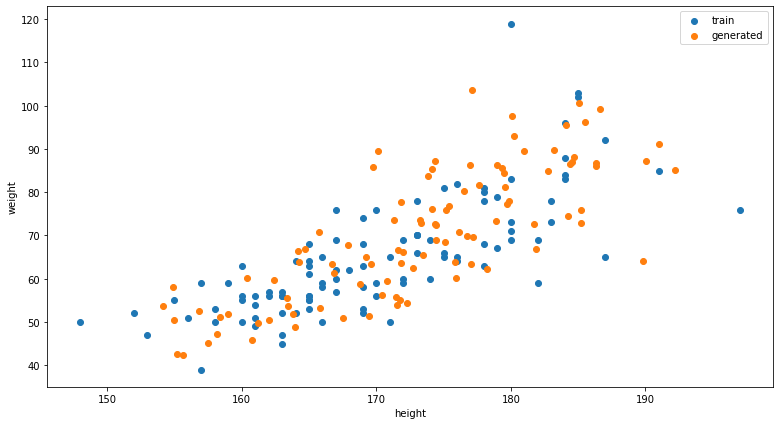

In [22]:
plt.scatter(x=train_davis_df["height"], y=train_davis_df["weight"], label="train")
plt.scatter(x=generated_data.T[1], y=generated_data.T[2], label="generated")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()

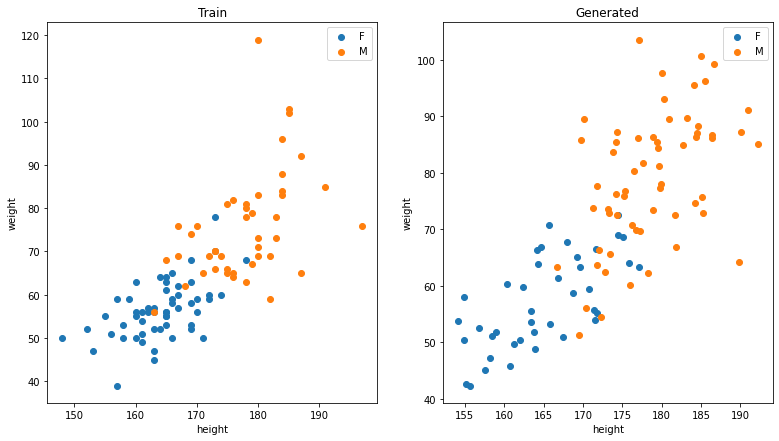

In [23]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(x=train_davis_df.where(train_davis_df["sex"] == "F")["height"],
              y=train_davis_df.where(train_davis_df["sex"] == "F")["weight"], label="F")
ax[0].scatter(x=train_davis_df.where(train_davis_df["sex"] == "M")["height"],
              y=train_davis_df.where(train_davis_df["sex"] == "M")["weight"], label="M")
ax[0].set_xlabel("height")
ax[0].set_ylabel("weight")
ax[0].set_title("Train")
ax[0].legend()
x_f = []
x_m = []
y_f = []
y_m = []
for i in range(len(generated_data)):
    if(generated_data[i][0] == 1):
        x_f.append(generated_data[i][1])
        y_f.append(generated_data[i][2])
    else:
        x_m.append(generated_data[i][1])
        y_m.append(generated_data[i][2])
ax[1].scatter(x=x_f, y=y_f, label="F")
ax[1].scatter(x=x_m, y=y_m, label="M")
ax[1].set_xlabel("height")
ax[1].set_ylabel("weight")
ax[1].set_title("Generated")
ax[1].legend()

# Задание 2

## a)Обучение линейной модели градиентным спуском

### Улучшение параметров (w1, b)

In [24]:
def param_upgrade(df, w1, b, alpha):
    N = len(df.index)
    dQ_dw1 = 0
    dQ_db = 0
    x = df["height"].to_numpy()
    y = df["weight"].to_numpy()
    
    
    for i in range(N):
        dQ_dw1 += (-2 * x[i] * (y[i] - w1 * x[i] - b) / N)
        dQ_db += (-2 * (y[i] - w1 * x[i] - b) / N )
        
        
    w1 = w1 - alpha * dQ_dw1
    b = b - alpha * dQ_db
    return w1, b

In [25]:
param_upgrade(train_davis_df, 0, 0, 0.001)

(22.279040000000002, 0.1298400000000001)

### Подсчет среднеквадратической ошибки

In [26]:
def squared_error_loss(df, w1, b):
    N = len(df.index)
    error = 0
    x = df["height"].to_numpy()
    y = df["weight"].to_numpy()
    for i in range(N):
        error += (y[i] - w1 * x[i] - b) ** 2
    return error / N  

### Градиентный спуск

In [27]:
def gradient_descent(df, epoches_N, alpha):   
    w1 = -1
    b = -1
    w1_history = []
    b_history = []
    loss_history = []
    for i in range(epoches_N):
        w1, b = param_upgrade(df, w1, b, alpha)
        w1_history.append(w1)
        b_history.append(b)
        if i % 100 == 0:
            print(f"Loss in {i} epoch:" + str(squared_error_loss(df, w1, b)))
        loss_history.append(squared_error_loss(df, w1, b))
    return w1, b, w1_history, b_history, loss_history        

In [28]:
w1, b, w1_history, b_history, loss_history = gradient_descent(train_davis_df, 1000, 1e-3)

Loss in 0 epoch:182537642.04119343
Loss in 100 epoch:inf
Loss in 200 epoch:nan
Loss in 300 epoch:nan

<ipython-input-26-dbb66dd7cb54>:7: RuntimeWarning: overflow encountered in double_scalars
  error += (y[i] - w1 * x[i] - b) ** 2
<ipython-input-24-807c16274594>:10: RuntimeWarning: overflow encountered in double_scalars
  dQ_dw1 += (-2 * x[i] * (y[i] - w1 * x[i] - b) / N)
<ipython-input-24-807c16274594>:14: RuntimeWarning: invalid value encountered in double_scalars
  w1 = w1 - alpha * dQ_dw1



Loss in 400 epoch:nan
Loss in 500 epoch:nan
Loss in 600 epoch:nan
Loss in 700 epoch:nan
Loss in 800 epoch:nan
Loss in 900 epoch:nan


In [29]:
w1, b

(nan, nan)

In [30]:
for i in range(len(w1_history)):
    if i % 100 == 0:
        print(f"w1 in {i} epoch:" + str(w1_history[i]))

w1 in 0 epoch:79.68152000000002
w1 in 100 epoch:3.432521900261937e+177
w1 in 200 epoch:nan
w1 in 300 epoch:nan
w1 in 400 epoch:nan
w1 in 500 epoch:nan
w1 in 600 epoch:nan
w1 in 700 epoch:nan
w1 in 800 epoch:nan
w1 in 900 epoch:nan


In [31]:
for i in range(len(b_history)):
    if i % 100 == 0:
        print(f"w1 in {i} epoch:" + str(b_history[i]))

w1 in 0 epoch:-0.5278999999999999
w1 in 100 epoch:2.0115490282570247e+175
w1 in 200 epoch:nan
w1 in 300 epoch:nan
w1 in 400 epoch:nan
w1 in 500 epoch:nan
w1 in 600 epoch:nan
w1 in 700 epoch:nan
w1 in 800 epoch:nan
w1 in 900 epoch:nan


### Нормализируем данные

In [32]:
def normalize(df):
    df = df.copy()
    df["height"] = (df["height"] - df["height"].mean()) / df["height"].std()
    df["weight"] = (df["weight"] - df["weight"].mean()) / df["weight"].std() 
    return df 
normalize(train_davis_df)

,Unnamed: 0,sex,weight,height,repwt,repht
101,102.0,M,-0.141260,0.840039,63.000000,175.000000
57,58.0,M,0.594470,1.373737,74.000000,180.000000
121,122.0,M,0.300178,-0.334094,73.000000,165.000000
37,38.0,M,0.300178,0.413082,69.000000,171.000000
35,36.0,M,-0.067687,0.626561,65.000000,175.000000
...,...,...,...,...,...,...
126,127.0,F,-1.318428,-1.828447,65.675824,154.000000
91,92.0,F,-0.656271,-0.974531,56.000000,161.000000
176,177.0,F,-0.361979,0.413082,65.675824,168.527473
47,48.0,F,-1.171282,-0.974531,65.675824,168.527473


In [33]:
w1, b, w1_history, b_history, loss_history = gradient_descent(normalize(train_davis_df), 1000, 0.001)

Loss in 0 epoch:4.451071997798241
Loss in 100 epoch:3.132978663630952
Loss in 200 epoch:2.2471255116027513
Loss in 300 epoch:1.6517669423697052
Loss in 400 epoch:1.2516409321724244
Loss in 500 epoch:0.9827251715671714
Loss in 600 epoch:0.8019923520873543
Loss in 700 epoch:0.6805251343204582
Loss in 800 epoch:0.598888999514729
Loss in 900 epoch:0.5440225229240658


In [34]:
w1, b

(0.5097569395239162, -0.13506452244668385)

In [35]:
for i in range(len(w1_history)):
    if i % 100 == 0:
        print(f"w1 in {i} epoch:" + str(w1_history[i]))

w1 in 0 epoch:-0.9965329232816456
w1 in 100 epoch:-0.6823331825225567
w1 in 200 epoch:-0.42462377528316175
w1 in 300 epoch:-0.21324823939243387
w1 in 400 epoch:-0.039876154718831186
w1 in 500 epoch:0.10232516303257387
w1 in 600 epoch:0.21895994197236301
w1 in 700 epoch:0.3146248195800043
w1 in 800 epoch:0.3930899985847113
w1 in 900 epoch:0.45744783262169286


In [36]:
for i in range(len(b_history)):
    if i % 100 == 0:
        print(f"w1 in {i} epoch:" + str(b_history[i]))

w1 in 0 epoch:-0.998
w1 in 100 epoch:-0.8169296710790512
w1 in 200 epoch:-0.6687115105103475
w1 in 300 epoch:-0.547385044416827
w1 in 400 epoch:-0.4480712267425153
w1 in 500 epoch:-0.366776232347445
w1 in 600 epoch:-0.3002308485483082
w1 in 700 epoch:-0.245759006365084
w1 in 800 epoch:-0.2011701645636699
w1 in 900 epoch:-0.16467121880552854


In [37]:
for i in range(len(loss_history)):
    if i % 100 == 0:
        print(f"w1 in {i} epoch:" + str(loss_history[i]))

w1 in 0 epoch:4.451071997798241
w1 in 100 epoch:3.132978663630952
w1 in 200 epoch:2.2471255116027513
w1 in 300 epoch:1.6517669423697052
w1 in 400 epoch:1.2516409321724244
w1 in 500 epoch:0.9827251715671714
w1 in 600 epoch:0.8019923520873543
w1 in 700 epoch:0.6805251343204582
w1 in 800 epoch:0.598888999514729
w1 in 900 epoch:0.5440225229240658


In [38]:
def predict(x, w1, b):
    return w1 * x + b

Text(0, 0.5, 'weight')

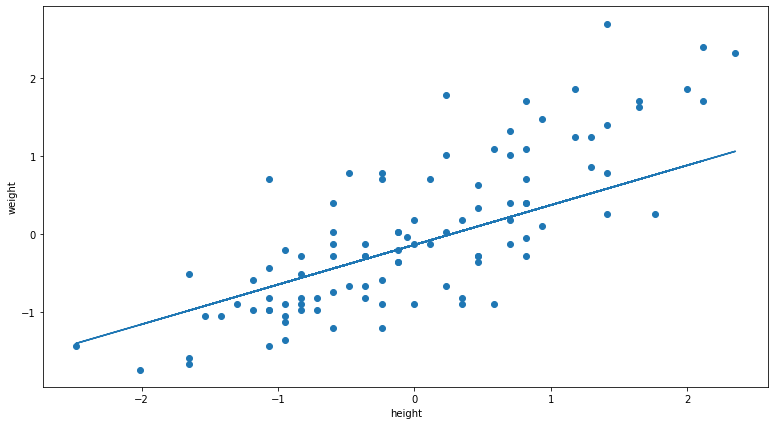

In [39]:
norm_test_df = normalize(test_davis_df)
x = norm_test_df["height"]
y = norm_test_df["weight"]
plt.scatter(x, y)
plt.plot(x, predict(x, w1, b))
plt.xlabel("height")
plt.ylabel("weight")

### Визуализация

Text(0, 0.5, 'w1')

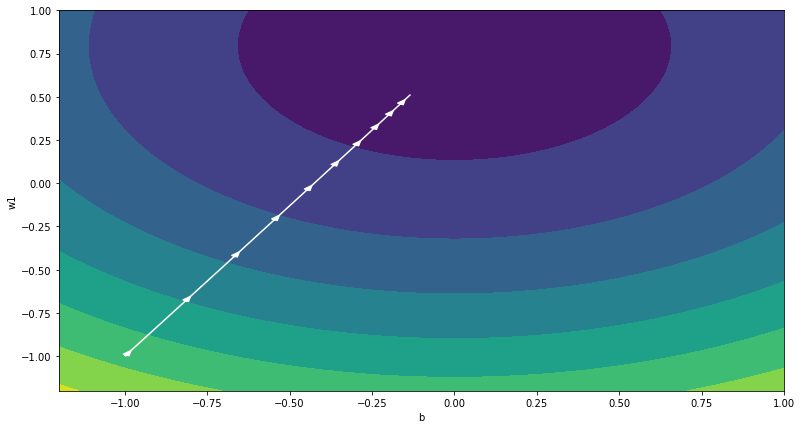

In [40]:
x = np.linspace(-1.2, 1, 100)
y = np.linspace(-1.2, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(shape=(x.size, y.size))
for i in range(len(x)):
    for j in range(len(y)):
        loss = squared_error_loss(norm_test_df, x[i], y[j])
        Z[i, j] = loss
plt.contourf(X, Y, Z)
plt.plot(b_history, w1_history, color="WHITE")
for i in range(len(b_history)):
    if i % 100 == 0:
        plt.arrow(b_history[i], w1_history[i], b_history[i + 1] - b_history[i], w1_history[i + 1] - w1_history[i],
                  width=0.007, color="WHITE")
plt.xlabel("b")
plt.ylabel("w1")

## б)Обучение линейной модели градиентным спуском

In [41]:
def sex_converter(df):
    converted_df = df.copy()
    converted_df["sex"] = (converted_df["sex"] == "M").values.astype(int)
    return converted_df

In [42]:
sex_converter(train_davis_df)

,Unnamed: 0,sex,weight,height,repwt,repht
101,102.0,1,63.0,178.0,63.000000,175.000000
57,58.0,1,73.0,183.0,74.000000,180.000000
121,122.0,1,69.0,167.0,73.000000,165.000000
37,38.0,1,69.0,174.0,69.000000,171.000000
35,36.0,1,64.0,176.0,65.000000,175.000000
...,...,...,...,...,...,...
126,127.0,0,47.0,153.0,65.675824,154.000000
91,92.0,0,56.0,161.0,56.000000,161.000000
176,177.0,0,60.0,174.0,65.675824,168.527473
47,48.0,0,49.0,161.0,65.675824,168.527473


In [43]:
def param_upgrade(df, w1, w2, b, alpha):
    df = sex_converter(df)
    N = len(df.index)
    dQ_dw1 = 0
    dQ_dw2 = 0
    dQ_db = 0
    x1 = df["height"].to_numpy()
    x2 = df["sex"].to_numpy()
    y = df["weight"].to_numpy()
    
    for i in range(N):
        dQ_dw1 += (-2 * x1[i] * (y[i] - w1 * x1[i] - w2 * x2[i] - b) / N)
        dQ_dw2 += (-2 * x2[i] * (y[i] - w1 * x1[i] - w2 * x2[i] - b) / N)
        dQ_db += (-2 * (y[i] - w1 * x1[i] - w2 * x2[i] - b) / N )
        
        
    w1 = w1 - alpha * dQ_dw1
    w2 = w2 - alpha * dQ_dw2
    b = b - alpha * dQ_db
    return w1, w2, b

### Подсчет среднеквадратической ошибки

In [44]:
def squared_error_loss(df, w1, w2, b):
    df = sex_converter(df)
    N = len(df.index)
    error = 0
    x1 = df["height"].to_numpy()
    x2 = df["sex"].to_numpy()
    y = df["weight"].to_numpy()
    for i in range(N):
        error += (y[i] - w1 * x1[i] - w2 * x2[i] - b) ** 2
    return error / N  

In [45]:
def predict(x1, x2, w1, w2, b):
    return w1 * x1 + w2 * x2 + b;

In [46]:
def gradient_descent_2(df, epoches_N, alpha):   
    w1 = -1
    w2 = -1
    b = -1
    w1_history = []
    w2_history = []
    b_history = []
    loss_history = []
    for i in range(epoches_N):
        w1, w2, b = param_upgrade(df, w1, w2, b, alpha)
        w1_history.append(w1)
        w2_history.append(w2)
        b_history.append(b)
        if i % 100 == 0:
            print(f"Loss in {i} epoch:" + str(squared_error_loss(df, w1, w2, b)))
        loss_history.append(squared_error_loss(df, w1, w2, b))
    return w1, w2, b, w1_history, w2_history, b_history, loss_history        

In [47]:
w1, w2, b, w1_history, w2_history, b_history, loss_history = gradient_descent_2(normalize(train_davis_df), 1000, 0.001)

Loss in 0 epoch:7.172841494776213
Loss in 100 epoch:4.392698237180976
Loss in 200 epoch:2.7591517919309663
Loss in 300 epoch:1.7978290617758415
Loss in 400 epoch:1.2310680647955232
Loss in 500 epoch:0.8961978833543206
Loss in 600 epoch:0.697816918059374
Loss in 700 epoch:0.5799087384005425
Loss in 800 epoch:0.5095382983680121
Loss in 900 epoch:0.4673118832628315


In [48]:
w1, w2, b

(0.5287487223494353, 0.14837145231115742, -0.11267984274647927)

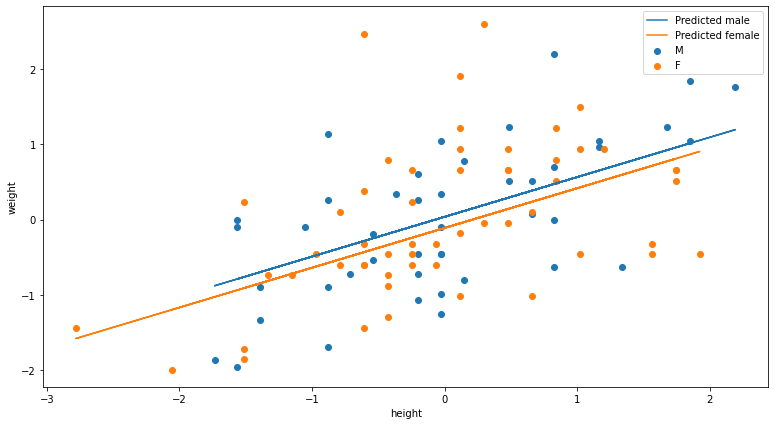

In [49]:
norm_test_df_male = normalize(test_davis_df[test_davis_df["sex"] == "M"])
norm_test_df_female = normalize(test_davis_df[test_davis_df["sex"] == "F"])
x1_male = norm_test_df_male["height"]
x1_female = norm_test_df_female["height"]
x2_male = 1
x2_female = 0
y_male = norm_test_df_male["weight"]
y_female = norm_test_df_female["weight"]
plt.scatter(x1_male, y_male, label="M")
plt.scatter(x1_female, y_female, label="F")
plt.plot(x1_male, predict(x1_male, x2_male, w1, w2, b), label="Predicted male")
plt.plot(x1_female, predict(x1_female, x2_female, w1, w2, b), label="Predicted female")
plt.xlabel("height")
plt.ylabel("weight")
plt.legend()